In [24]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ppg_dataset import PPGDataset

import config

sys.path.append(os.path.join(os.path.curdir, 'trained_model'))

from trained_model.src.models.utils import load_model
import trained_model.utils.consts as consts
from trained_model.src.train_and_eval import eval

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, recall_score
from sklearn.preprocessing import normalize

from pprint import pp, pprint

from tabulate import tabulate

import matplotlib
# reset the matplotlib settings to default
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [2]:
# Load 1D-CNN
af_1d_cnn = load_model(consts.path_models['1D-CNN'], algo='1D-CNN')['classifier']
af_1d_cnn

In [3]:
dataset = PPGDataset('data', freq=config.DFS)
dataset.process_signals()
all_windows = [x for x in dataset]

In [4]:
all_windows[0]

(array([  80., 1360., 1000.,  480.,  960.,  960.,  120., 1060.,  640.,
         340.,  540.,  300.,  740.,  120., 1420.,  720., 1200.,  520.,
         880.,  700.,  700.,  660.,  560.,  800.,  820.,  540.,  720.,
         340.,  380.,  580.,  840.,  580.,  720.,  620.,  840.,  720.,
         680.,  620.,  580.,  820., 1300., 1020.,  540.,  980.,  720.,
         800.,  680.,  660.,  600.,  660.,  740.,  280.,   40.,  440.,
         620.,  700.,  820.,  700.,  240., 1080.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 0,
 '4018')

In [27]:
def eval_af_predictions(y_true, y_score, threshold=0.5):
    y_predict = 1 * (y_score > threshold)
    scores_table = []
    scores_table.append(['Accuracy', metrics.accuracy_score(y_true, y_predict)])
    scores_table.append(['Precision', metrics.precision_score(y_true, y_predict)])
    scores_table.append(['Recall', metrics.recall_score(y_true, y_predict)])
    scores_table.append(['ROC AUC', metrics.roc_auc_score(y_true, y_score)])
    print(tabulate(scores_table))

    print('Confusion Matrix:')
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_predict).ravel()
    print(tabulate([
        [f'TP {tp}', f'FN {fn}'],
        [f'FP {fp}', f'TN {tn}']

    ]))
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
    plt.figure()
    plt.title("ROC Curve")
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    

In [21]:
y = [bool(max(w[1])) for w in all_windows]
X = [w[0] for w in all_windows]
X = np.vstack(X)

print(X.shape)

(2221, 60)


In [22]:
th = 0.5
x = X.reshape(X.shape[0], X.shape[1], 1)
y_score = af_1d_cnn.model.predict(x).reshape(-1)
y_score

70/70 [==============================] - 1s 12ms/step


array([1.4202676e-15, 0.0000000e+00, 1.0000000e+00, ..., 4.7629614e-18,
       0.0000000e+00, 1.0000000e+00], dtype=float32)

Precision: 0.05653710247349823
Recall: 0.7868852459016393
Accuracy: 0.6334984241332733
Confusion Matrix:
------  -------
TP 48   FN 13
FP 801  TN 1359
------  -------


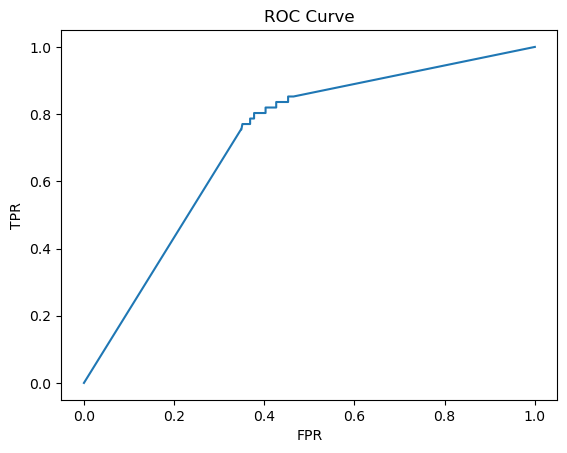

In [28]:
eval_af_predictions(y, y_score, threshold=0.5)

In [58]:
Z = normalize(X, axis=1)
y_predict = af_1d_cnn.predict(X)
accuracy_score(y,y_predict), f1_score(y, y_predict), recall_score(y, y_predict)

3/3 [==============================] - 1s 224ms/step


(0.6334984241332733, 0.10549450549450551, 0.7868852459016393)

In [ ]:
algo='ArNet2'
model_path = 'trained_model/saved_models/ArNet2/ArNet2.pkl'
feature_extractor_path = consts.path_models['ResNet']

model = load_model(model_path, algo, feature_extractor_path)
classifier = model['classifier']

In [ ]:
afdb_input = pickle.load(open('trained_model/inputs/AFDB_input.pickle', 'rb'))
afdb_input

In [ ]:
# y_true = []
# y_predict = []
# for x,y in dataset:
#     x = x.reshape(1,-1)
#     x = np.concatenate([x, np.zeros((1,60))],axis=1)[:,:63]
#     y_predict.append(classifier.predict_proba(x))

In [ ]:
x,y = dataset[0]
print(x.shape)
window_id = 0

x = np.concatenate([x, [0], [0], np.array(['PID1'])], dtype=object)
x

In [ ]:
classifier.predict_proba(x)